In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
np.random.seed(42)


In [27]:
n_customers = 500


In [28]:
data = {
    "CustomerID": [f"C{1000+i}" for i in range(n_customers)],
    "OrderFrequency": np.random.randint(1, 40, n_customers),
    "DaysSinceLastOrder": np.random.randint(1, 120, n_customers),
    "AvgRating": np.round(np.random.uniform(2.5, 5.0, n_customers), 1),
    "Complaints": np.random.randint(0, 6, n_customers)
}


In [29]:
df = pd.DataFrame(data)
df.head()


,CustomerID,OrderFrequency,DaysSinceLastOrder,AvgRating,Complaints
0,C1000,39,109,4.3,0
1,C1001,29,53,3.0,1
2,C1002,15,42,4.3,5
3,C1003,8,58,3.8,0
4,C1004,21,39,4.3,5


In [30]:
df["Churn"] = np.where(
    (df["DaysSinceLastOrder"] > 75) &
    (df["AvgRating"] < 3.5) &
    (df["Complaints"] >= 2),
    1, 0
)


In [31]:
df["Churn"].value_counts()


Churn
0    460
1     40
Name: count, dtype: int64

In [32]:
df.to_csv("zomato_customer_churn.csv", index=False)


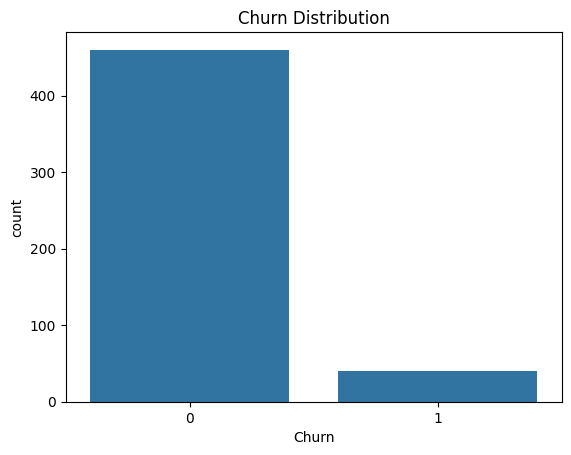

In [33]:
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()


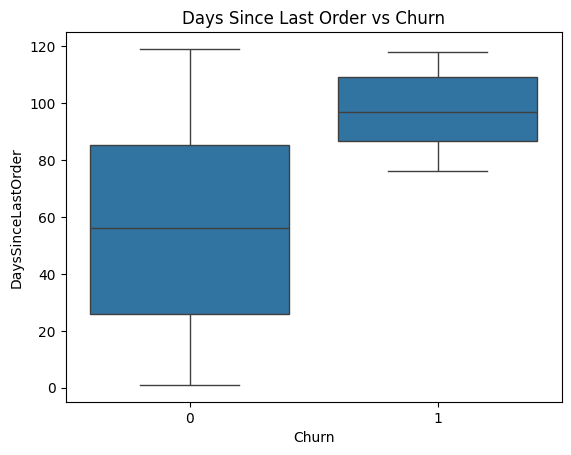

In [34]:
sns.boxplot(x="Churn", y="DaysSinceLastOrder", data=df)
plt.title("Days Since Last Order vs Churn")
plt.show()


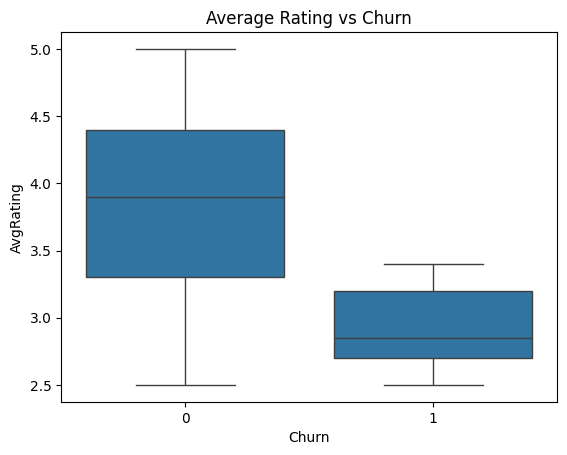

In [35]:
sns.boxplot(x="Churn", y="AvgRating", data=df)
plt.title("Average Rating vs Churn")
plt.show()


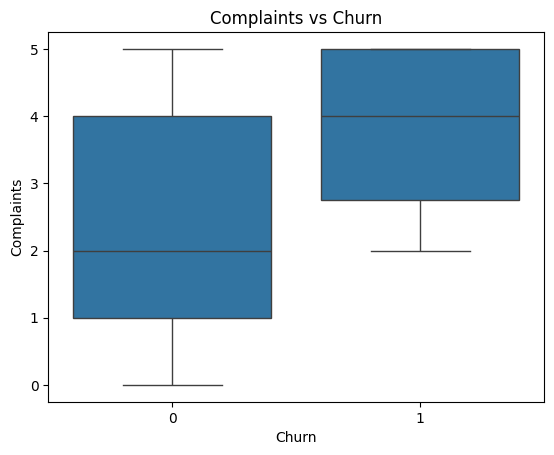

In [36]:
sns.boxplot(x="Churn", y="Complaints", data=df)
plt.title("Complaints vs Churn")
plt.show()


In [37]:
X = df[["OrderFrequency", "DaysSinceLastOrder", "AvgRating", "Complaints"]]
y = df["Churn"]


In [38]:
from sklearn.model_selection import train_test_split


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [40]:
from sklearn.linear_model import LogisticRegression


In [41]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [43]:
y_pred = model.predict(X_test)


In [44]:
accuracy_score(y_test, y_pred)


0.91

In [45]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.91      0.95        92
           1       0.47      0.88      0.61         8

    accuracy                           0.91       100
   macro avg       0.73      0.89      0.78       100
weighted avg       0.95      0.91      0.92       100



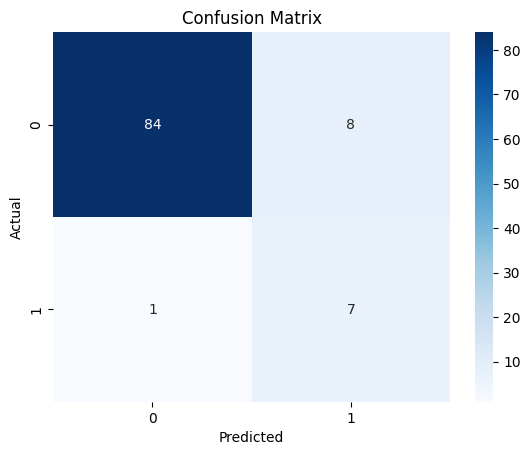

In [46]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [47]:
importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

importance


,Feature,Coefficient
3,Complaints,0.762865
1,DaysSinceLastOrder,0.088573
0,OrderFrequency,-0.027089
2,AvgRating,-3.727136


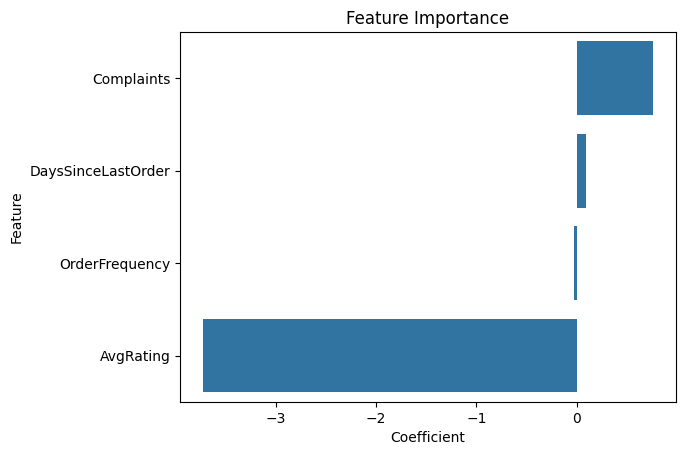

In [48]:
sns.barplot(x="Coefficient", y="Feature", data=importance)
plt.title("Feature Importance")
plt.show()


In [49]:
df.head()


,CustomerID,OrderFrequency,DaysSinceLastOrder,AvgRating,Complaints,Churn
0,C1000,39,109,4.3,0,0
1,C1001,29,53,3.0,1,0
2,C1002,15,42,4.3,5,0
3,C1003,8,58,3.8,0,0
4,C1004,21,39,4.3,5,0


In [50]:
test_customer = pd.DataFrame({
    "OrderFrequency": [1],
    "DaysSinceLastOrder": [120],
    "AvgRating": [2.8],
    "Complaints": [4]
})

model.predict(test_customer), model.predict_proba(test_customer)


(array([1]), array([[0.00177791, 0.99822209]]))

In [54]:
y_prob = model.predict_proba(X_test)[:, 1]


In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

auc_score


0.9605978260869565

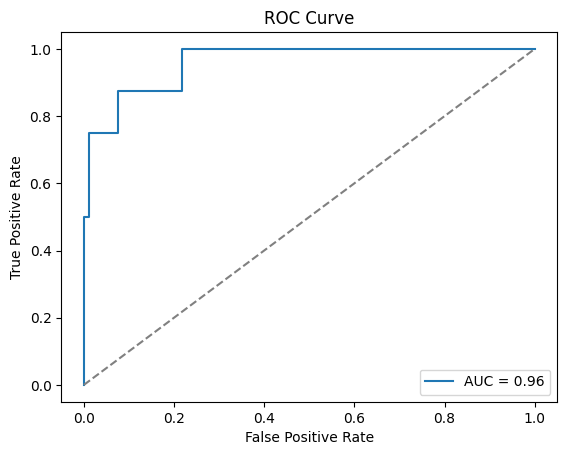

In [56]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [57]:
threshold = 0.5


In [58]:
custom_threshold = 0.4
y_custom_pred = (y_prob >= custom_threshold).astype(int)


In [59]:
from sklearn.metrics import classification_report

print("Default Threshold (0.5):")
print(classification_report(y_test, y_pred))

print("\nCustom Threshold (0.4):")
print(classification_report(y_test, y_custom_pred))


Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        92
           1       0.47      0.88      0.61         8

    accuracy                           0.91       100
   macro avg       0.73      0.89      0.78       100
weighted avg       0.95      0.91      0.92       100


Custom Threshold (0.4):
              precision    recall  f1-score   support

           0       0.99      0.85      0.91        92
           1       0.33      0.88      0.48         8

    accuracy                           0.85       100
   macro avg       0.66      0.86      0.70       100
weighted avg       0.94      0.85      0.88       100



In [60]:
import joblib

joblib.dump(model, "churn_model.pkl")


['churn_model.pkl']